In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
%matplotlib inline

In [20]:
PATH_DATA = './PhonePi/data/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]

In [21]:
DIR

['./PhonePi/data/camminata-alberto',
 './PhonePi/data/camminata-alberto.2',
 './PhonePi/data/camminata-anna',
 './PhonePi/data/camminata-daniele',
 './PhonePi/data/camminata-emanuele',
 './PhonePi/data/camminata-luisa',
 './PhonePi/data/camminata-luisa.2',
 './PhonePi/data/camminata-simone',
 './PhonePi/data/camminata_tasca-alberto',
 './PhonePi/data/camminata_tasca-alberto.2',
 './PhonePi/data/camminata_tasca-daniele',
 './PhonePi/data/camminata_tasca-emanuele',
 './PhonePi/data/camminata_tasca-luisa',
 './PhonePi/data/camminata_tasca-luisa.2',
 './PhonePi/data/camminata_tasca-simone',
 './PhonePi/data/corsa-alberto',
 './PhonePi/data/corsa-anna',
 './PhonePi/data/corsa-daniele',
 './PhonePi/data/corsa-luisa',
 './PhonePi/data/corsa_tasca-alberto',
 './PhonePi/data/corsa_tasca-anna',
 './PhonePi/data/corsa_tasca-daniele',
 './PhonePi/data/corsa_tasca-francesco',
 './PhonePi/data/corsa_tasca-luisa',
 './PhonePi/data/quotidiano-alberto',
 './PhonePi/data/quotidiano-anna',
 './PhonePi/da

100%|██████████████████████████████████████████| 40/40 [00:11<00:00,  2.86it/s]


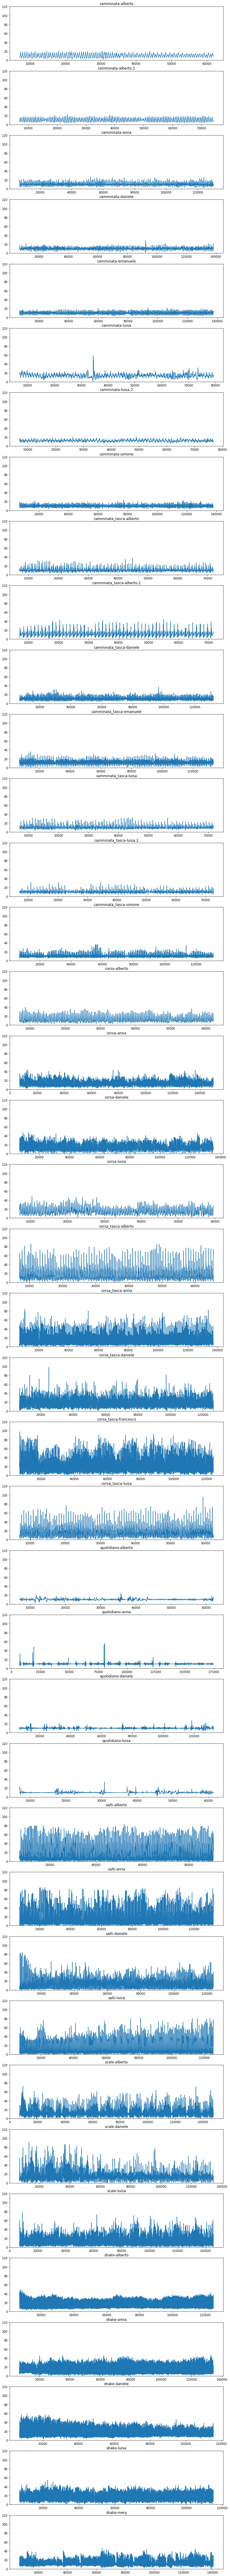

In [22]:
plt.figure(figsize=(13,4*len(DIR)))
nrow = len(DIR)
for i in tqdm.tqdm(range(len(DIR))):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
    data["t"] = data["t"] - data["t"].iloc[0]
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))]
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    ax = plt.subplot(nrow, 1, i+1, ylim=(0,120))
    ax.set_title(DIR[i].split("/")[-1])
    plt.plot(data["t"],data["a"])
    
plt.show()

In [24]:
tipo=[(dir.split("/")[-1]).split(".")[0] for dir in DIR]
tipo

['camminata-alberto',
 'camminata-alberto',
 'camminata-anna',
 'camminata-daniele',
 'camminata-emanuele',
 'camminata-luisa',
 'camminata-luisa',
 'camminata-simone',
 'camminata_tasca-alberto',
 'camminata_tasca-alberto',
 'camminata_tasca-daniele',
 'camminata_tasca-emanuele',
 'camminata_tasca-luisa',
 'camminata_tasca-luisa',
 'camminata_tasca-simone',
 'corsa-alberto',
 'corsa-anna',
 'corsa-daniele',
 'corsa-luisa',
 'corsa_tasca-alberto',
 'corsa_tasca-anna',
 'corsa_tasca-daniele',
 'corsa_tasca-francesco',
 'corsa_tasca-luisa',
 'quotidiano-alberto',
 'quotidiano-anna',
 'quotidiano-daniele',
 'quotidiano-luisa',
 'salti-alberto',
 'salti-anna',
 'salti-daniele',
 'salti-luisa',
 'scale-alberto',
 'scale-daniele',
 'scale-luisa',
 'shake-alberto',
 'shake-anna',
 'shake-daniele',
 'shake-luisa',
 'shake-mery']

In [25]:
tipo=[dir.split("-")[0] for dir in tipo]
tipo

['camminata',
 'camminata',
 'camminata',
 'camminata',
 'camminata',
 'camminata',
 'camminata',
 'camminata',
 'camminata_tasca',
 'camminata_tasca',
 'camminata_tasca',
 'camminata_tasca',
 'camminata_tasca',
 'camminata_tasca',
 'camminata_tasca',
 'corsa',
 'corsa',
 'corsa',
 'corsa',
 'corsa_tasca',
 'corsa_tasca',
 'corsa_tasca',
 'corsa_tasca',
 'corsa_tasca',
 'quotidiano',
 'quotidiano',
 'quotidiano',
 'quotidiano',
 'salti',
 'salti',
 'salti',
 'salti',
 'scale',
 'scale',
 'scale',
 'shake',
 'shake',
 'shake',
 'shake',
 'shake']

In [26]:
p = 150 # numero osservazioni per intervallo
nomi_colonna=["user","azione"]
nomi_colonna.extend(["a"+str(i) for i in range(p)])
nomi_colonna
X=pd.DataFrame(columns=nomi_colonna)

for i in tqdm.tqdm(range(len(DIR))):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"]) # lettura dati
    data["t"] = data["t"] - data["t"].iloc[0] # t0 = 0
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))] # tolti i primi e ultimi 7 secondi
    data.reset_index(drop=True, inplace=True) # ripristinati gli indici da 0 in avanti
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    nome = [data.user[j] for j in range(0,len(data)-p, p)] # intervalli di dt*100ms
    tipologia=[tipo[i]]*len(nome)
    righe=[[nome[j],tipologia[j]] for j in range(len(nome))]
    [righe[j].extend(list(data.a[j*p:(j+1)*p])) for j in range(len(nome))]
    X=pd.concat([X,pd.DataFrame(righe,columns=nomi_colonna)],ignore_index=True) # ignore_index=T per avere indici consecutivi

100%|██████████████████████████████████████████| 40/40 [00:05<00:00,  7.20it/s]


In [27]:
y = X.azione
X.drop("azione", axis=1, inplace=True)
Xnum = X.drop("user", axis=1)

### Variabili di riassunto
Sono state calcolate le seguenti variabili di riassunto del segnale, nell'intervallo ampio 1500 ms di osservazione:
1. Integrale del segnale nell'intervallo, calcolato con l'approssimazione per trapezi.
2. Massimo dell'accelerazione nell'intervallo.
3. Variazione media assoluta della derivata nell'intervallo.

In [28]:
# Funzioni per calcolare variazione media della derivata e sbiancare i dati
from funzioni import AbsMeanVarDeriv, Whiten

In [29]:
intTrapz = pd.DataFrame(np.trapz(Xnum, dx=10)) # integrale con approssimazione per trapezi
maxA = Xnum.max(1) # massimo accelerazione
MVDeriv = AbsMeanVarDeriv(Xnum, 10) # variazione media della derivata
Mean = Xnum.mean(axis=1)
Var = Xnum.var(axis=1)
Med = Xnum.median(axis=1)
Min = Xnum.min(axis=1)

In [30]:
sum(Var<0)

0

In [31]:
# Costruzione del dataframe delle esplicative
#espl = pd.concat([intTrapz, maxA, MVDeriv, Mean], axis=1)
#espl.columns=["intTrapz", "maxA", "MVDeriv", "meanA"]
espl = pd.concat([maxA, MVDeriv, Mean, Var, Med, Min], axis=1)
espl.columns=["maxA", "MVDeriv", "meanA", "Var", "Med", "Min"]

from sklearn.manifold import TSNE
from funzioni import Whiten
esplWh = Whiten().fit_transform(espl)

tsne = TSNE(n_components=2, random_state=42)
esplTSNE = tsne.fit_transform(esplWh)

esplTSNE = pd.DataFrame(esplTSNE)

In [32]:
X.to_pickle("X-2s.pkl")
y.to_pickle("y-2s.pkl")
espl.to_pickle("espl.pkl")

In [33]:
X.to_csv("X-2s.csv")
y.to_csv("y-2s.csv")
espl.to_csv("espl.csv")